In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [32]:
data = pd.concat(
    [
        pd.read_csv(f, sep='\s+').assign(group=f.name.removesuffix('_report.txt')) for f in Path('.').glob('*report.txt')
    ], ignore_index=True)

# convert RSS to MB
conversion = np.ones_like(data['ReqCPUS'])
conversion[data.MaxRSS.str.endswith('K')] = 1024
conversion[data.MaxRSS.str.endswith('M')] = 1024 ** 2
data['MaxRSS'] = pd.to_numeric(data.MaxRSS.str.rstrip('KM')) * conversion / 1024**2

# convert elapsed time elapsed minutes
data['Elapsed'] = pd.to_timedelta(data.Elapsed).dt.total_seconds() / 60
data['Elapsed_cpu'] = data.Elapsed * data.ReqCPUS
data['mean_size'] = data.total_size / data.count_sequence
data['group'] = data['group'].map({
    '100_1': '100_bin',
    '100_2': '100_bin',
    '100_3': '100_bin',
    '1': '1_bin',
    '50': '50_bin',
    '10': '10_bin',
    'overall': '10_random',
})
data

,JobID,Elapsed,MaxRSS,ReqCPUS,count_sequence,min_size,max_size,total_size,group,Elapsed_cpu,mean_size
0,monomer_FE-54906582,7.683333,997.945312,1,100,900,999,94876,100_bin,7.683333,948.760000
1,monomer_FE-54906586,0.083333,0.000000,1,1,69,69,69,100_bin,0.083333,69.000000
2,monomer_FE-54906587,1.083333,67.031250,1,40,303,396,14138,100_bin,1.083333,353.450000
3,monomer_FE-54906589,1.033333,80.835938,1,19,204,297,4640,100_bin,1.033333,244.210526
4,monomer_FE-54906590,0.133333,0.000000,1,7,159,189,1209,100_bin,0.133333,172.714286
...,...,...,...,...,...,...,...,...,...,...,...
559,monomer_FE-54923162,1.716667,1836.570312,1,10,1215,1280,12485,10_bin,1.716667,1248.500000
560,monomer_FE-54923163,0.633333,1061.859375,1,10,807,888,8538,10_bin,0.633333,853.800000
561,monomer_FE-54923164,15.350000,2284.332031,1,10,2807,2883,28412,10_bin,15.350000,2841.200000
562,monomer_FE-54923165,7.200000,1775.203125,1,10,2114,2191,21450,10_bin,7.200000,2145.000000


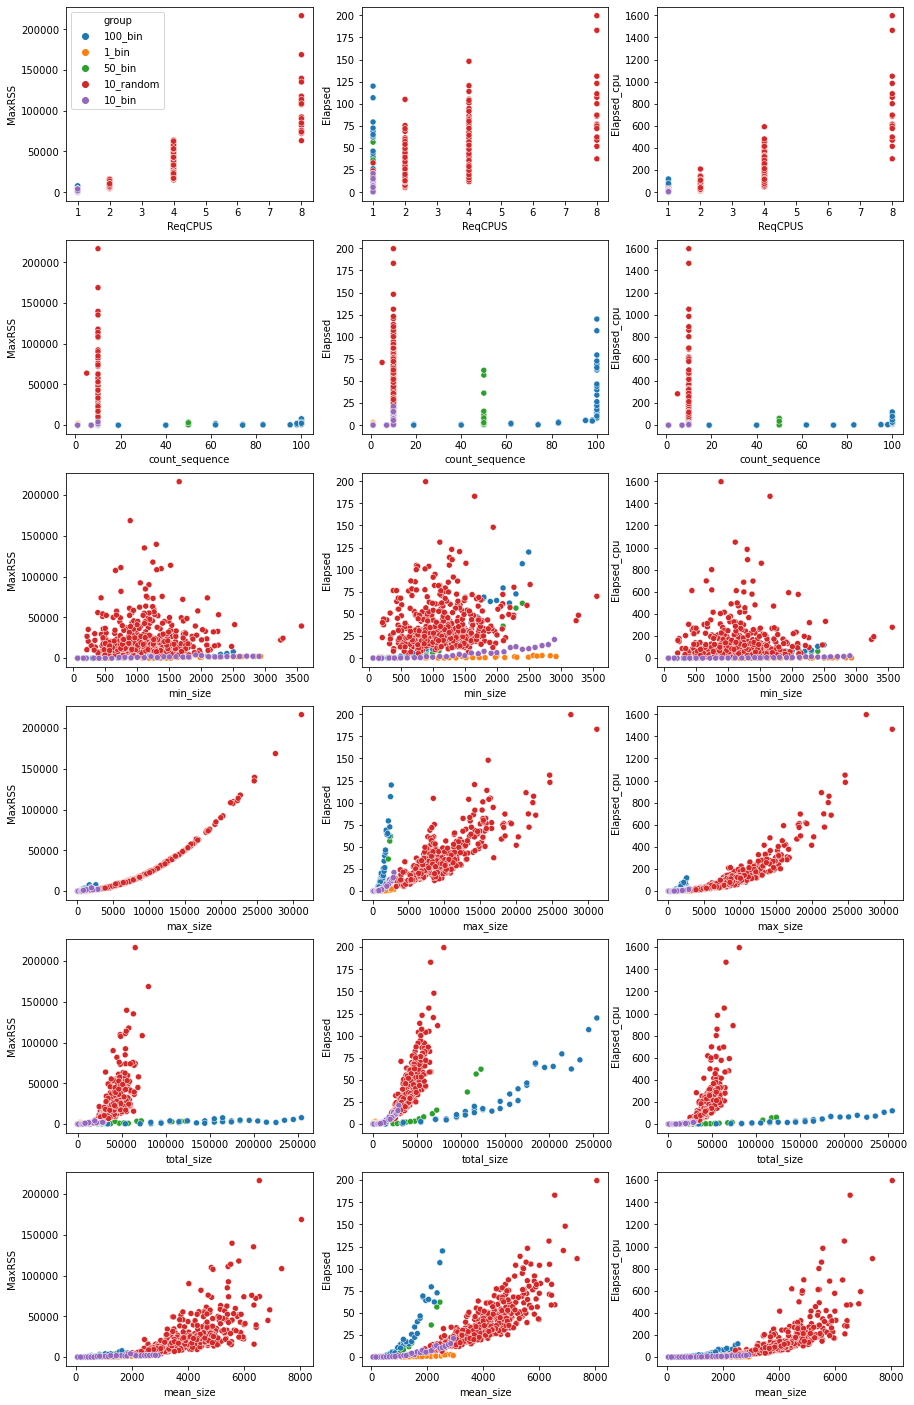

In [19]:
fig, axes = plt.subplots(6, 3, figsize=(15, 25))
for col, col_name in enumerate(('MaxRSS', 'Elapsed', 'Elapsed_cpu')):
    for row, row_name in enumerate(('ReqCPUS', 'count_sequence', 'min_size', 'max_size', 'total_size', 'mean_size')):
        sns.scatterplot(data=data, x=row_name, y=col_name, ax=axes[row, col], hue='group', legend=row==0 and col==0)

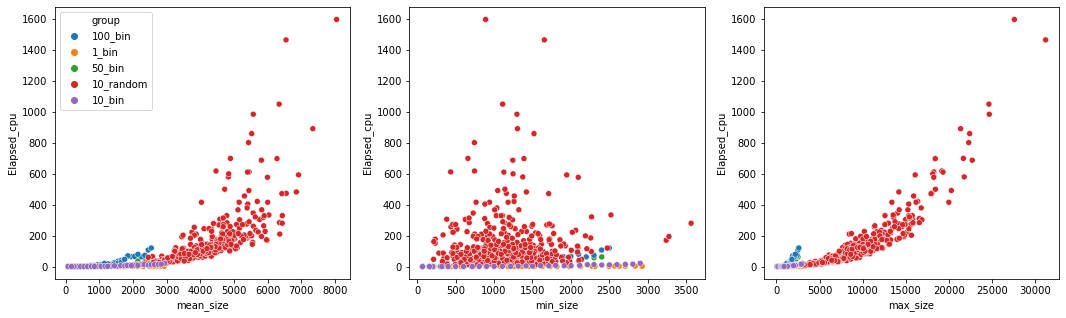

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), squeeze=False)
for col, col_name in enumerate(('mean_size', 'min_size', 'max_size' )):
    for row, row_name in enumerate(('Elapsed_cpu', )):
        sns.scatterplot(data=data, x=col_name, y=row_name, ax=axes[row, col], hue='group', legend=row==0 and col==0)

<AxesSubplot:xlabel='max_size', ylabel='Elapsed_cpu'>

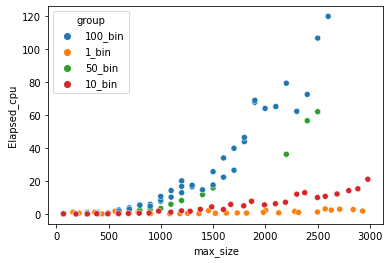

In [20]:
sns.scatterplot(data=data[data.group != '10_random'], x='max_size', y='Elapsed_cpu', hue='group')

<AxesSubplot:xlabel='max_size', ylabel='MaxRSS'>

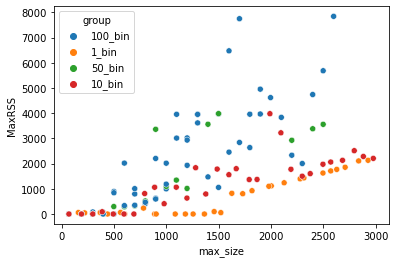

In [21]:
sns.scatterplot(data=data[data.group != '10_random'], x='max_size', y='MaxRSS', hue='group')

In [39]:
# maxRSS and cpu time look quadratically related to max_length, especially for a given number of sequences.  Focusing on just the overall data
data = data[data.group == '10_random'].copy()
data

,JobID,Elapsed,MaxRSS,ReqCPUS,count_sequence,min_size,max_size,total_size,group,Elapsed_cpu,mean_size
103,monomer_FE-54933703,19.100000,3975.621094,1,10,1671,4059,26175,10_random,19.100000,2617.5
104,monomer_FE-54933714,21.516667,3983.523438,1,10,522,4605,29629,10_random,21.516667,2962.9
105,monomer_FE-54933735,14.150000,3975.128906,1,10,936,3950,22858,10_random,14.150000,2285.8
106,monomer_FE-54933767,15.000000,2403.179688,1,10,1064,3137,23556,10_random,15.000000,2355.6
107,monomer_FE-54933819,18.383333,3935.417969,1,10,669,3940,25560,10_random,18.383333,2556.0
...,...,...,...,...,...,...,...,...,...,...,...
529,monomer_FE-55028625,199.533333,168793.421875,8,10,890,27596,80500,10_random,1596.266667,8050.0
530,monomer_FE-55028626,123.000000,139720.535156,8,10,1298,24683,55743,10_random,984.000000,5574.3
531,monomer_FE-55028627,111.316667,108516.031250,8,10,1305,21356,73446,10_random,890.533333,7344.6
532,monomer_FE-55028628,131.166667,135269.378906,8,10,1112,24641,63429,10_random,1049.333333,6342.9


Text(0, 0.5, 'Max RSS (GB)')

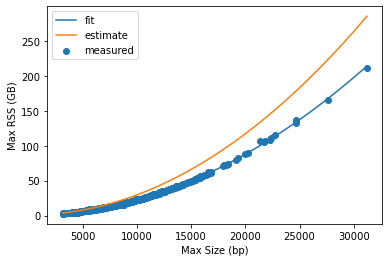

In [61]:
# maxRSS
model = np.poly1d(np.polyfit(data['max_size'], data['MaxRSS'], 2))
polyline = np.linspace(data['max_size'].min(), data['max_size'].max(), 50)
fig, ax = plt.subplots()
ax.scatter(x=data['max_size'], y=data['MaxRSS'] / 1024, label='measured')
ax.plot(polyline, model(polyline) / 1024, label='fit')

def pred_rss(max_size):
    params = reversed([ 2.25781141e-04, -5.44149562e-02,  7.49893677e+02])
    min_rss = 2*1024
    est = sum(param * max_size ** order for order, param in enumerate(params)) / 0.75  # target 80% eff
    # must be above minimum
    return np.maximum(est, min_rss)
    
ax.plot(polyline, pred_rss(polyline) / 1024, label='estimate')
ax.legend()
ax.set_xlabel('Max Size (bp)')
ax.set_ylabel('Max RSS (GB)')

Text(0, 0.5, 'Max RSS (GB)')

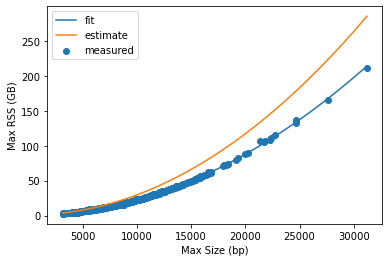

In [69]:
# maxRSS
x = data['max_size']**2 * data['total_size']**0.2
x = data['max_size']#**2 * data['total_size']**0.2
model = np.poly1d(np.polyfit(data['max_size'], data['MaxRSS'], 2))
polyline = np.linspace(data['max_size'].min(), data['max_size'].max(), 50)
fig, ax = plt.subplots()
ax.scatter(x=data['max_size'], y=data['MaxRSS'] / 1024, label='measured')
ax.plot(polyline, model(polyline) / 1024, label='fit')

def pred_rss(max_size):
    params = reversed([ 2.25781141e-04, -5.44149562e-02,  7.49893677e+02])
    min_rss = 2*1024
    est = sum(param * max_size ** order for order, param in enumerate(params)) / 0.75  # target 80% eff
    # must be above minimum
    return np.maximum(est, min_rss)
    
    
ax.plot(polyline, pred_rss(polyline) / 1024, label='estimate')
ax.legend()
ax.set_xlabel('Max Size (bp)')
ax.set_ylabel('Max RSS (GB)')

0.0 0.7503421927280297


Text(0, 0.5, 'Memory Efficiency')

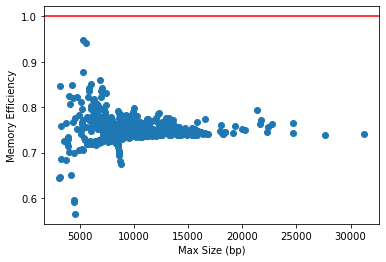

In [70]:
fig, ax = plt.subplots()
ax.scatter(x=data['max_size'], y=(data['MaxRSS'] / pred_rss(x)))
print((data['MaxRSS'] / pred_rss(x) > 1).sum() / len(data) * 100, (data['MaxRSS'] / pred_rss(x)).mean())
ax.axhline(1, color='r')

ax.set_xlabel('Max Size (bp)')
ax.set_ylabel('Memory Efficiency')

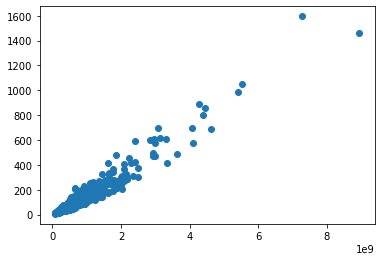

In [26]:
plt.scatter(x=data['max_size']**2 * data['total_size']**0.2, y=data['Elapsed_cpu'])

poly1d([ 2.05496072e-06, -1.26717081e-02,  4.20135600e+01])

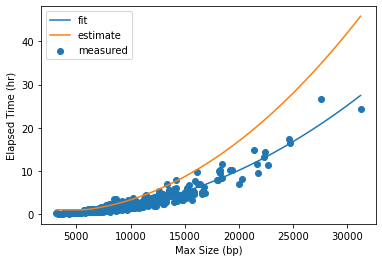

In [74]:
# total time
x = data['max_size']
model = np.poly1d(np.polyfit(x, data['Elapsed_cpu'], 2))
polyline = np.linspace(x.min(), x.max(), 50)
fig, ax = plt.subplots()
ax.scatter(x=data['max_size'], y=data['Elapsed_cpu'] / 60, label='measured')
ax.plot(polyline, model(polyline) / 60, label='fit')

def pred_time(max_size):
    params = reversed([ 2.05496072e-06, -1.26717081e-02,  4.20135600e+01])
    min_time = 63
    est = sum(param * max_size ** order for order, param in enumerate(params)) / 0.6  # target 80% eff
    # must be above minimum
    return np.maximum(est, min_time)
   
    
ax.plot(polyline, pred_time(polyline) / 60, label='estimate')
ax.legend()
ax.set_xlabel('Max Size (bp)')
ax.set_ylabel('Elapsed Time (hr)')
model

3.0162412993039442 0.5821677483982697


Text(0, 0.5, 'Time Efficiency')

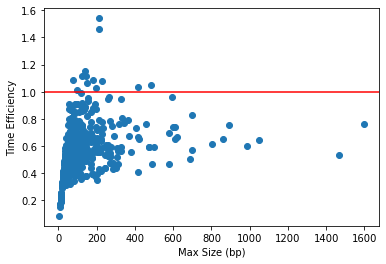

In [75]:
fig, ax = plt.subplots()
ax.scatter(x=data['Elapsed_cpu'], y=(data['Elapsed_cpu'] / pred_time(x)))
print((data['Elapsed_cpu'] / pred_time(x) > 1).sum() / len(data) * 100, (data['Elapsed_cpu'] / pred_time(x)).mean())
ax.axhline(1, color='r')

ax.set_xlabel('Max Size (bp)')
ax.set_ylabel('Time Efficiency')

(479764.16137199994, 235.25686566666667, 20.0)

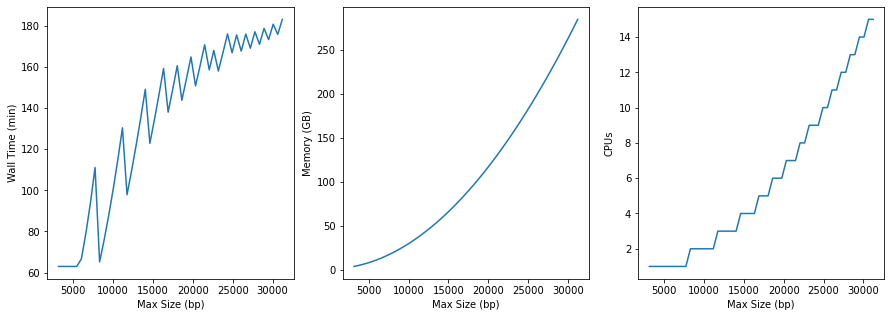

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# ax.plot(polyline, np.ceil(pred_rss(polyline) / 20000))

def pred_resources(max_size):
    max_rss = pred_rss(max_size)
    total_time = pred_time(max_size)
    cpus = np.ceil(np.clip(max_rss / 20000, 1, 20))
    time = total_time / cpus
    return max_rss, time, cpus

rss, time, cpus = pred_resources(polyline)
axes[0].plot(polyline, time)
axes[0].set_ylabel('Wall Time (min)')
axes[1].plot(polyline, rss / 1024)
axes[1].set_ylabel('Memory (GB)')
axes[2].plot(polyline, cpus)
axes[2].set_ylabel('CPUs')

for i in range(3):
    axes[i].set_xlabel('Max Size (bp)')

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]

# # now plot both limits against eachother
# ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# ax.set_aspect('equal')
# ax.set_xlim(lims)
# ax.set_ylim(lims)
pred_resources(40000)

<AxesSubplot:xlabel='max_size', ylabel='Count'>

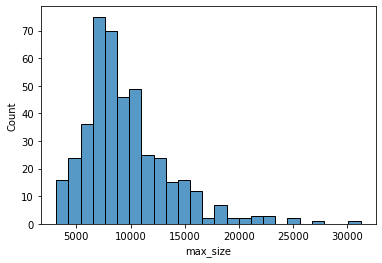

In [14]:
sns.histplot(data=data, x='max_size')

In [15]:
np.log10(40000)

4.6020599913279625

In [16]:
plt.plot(dat[1], dat[0])

NameError: name 'dat' is not defined

In [ ]:
250/4